In [ ]:
# Lecture 8: MCMC, convergence test and other considerations

In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import pandas as pd

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns

from scipy.stats import distributions

In [2]:
# Example. Bioassay experiment

In [6]:
n=5
X=np.array([-0.86,-0.30,-0.05,0.73])
Y=np.array([0,1,3,5])

In [7]:
## invLogit
logitInv= lambda x: np.exp(x)/(1.0+np.exp(x))

## posterior
def calc_posterior(a, b, y=Y, x=X):
    # Calculate joint posterior, given values for a, b 

    # Priors on a,b
    p = 1
    p = np.product((logitInv(a+b*x)**y)*(1.0-logitInv( a+b*x))**(n-y))
    
    return p

In [8]:
# check my posterior. I do a brute force just to make sure I do the right thing
X1 = np.linspace(-3,7,101)
X2 = np.linspace(-10, 30,100)
k=0;j=0
pp=np.zeros((101,100))
for x1 in X1:
    j=0
    for x2 in X2:
        pp[k,j]=calc_posterior(x1,x2)
        j +=1
    k +=1

In [9]:
# Lets define a MH method we can use later too

In [12]:
rnorm = np.random.normal
runif = np.random.rand

def metropolis(n_iterations, initial_values, prop_var=1):
    #np.random.seed(seed=1)
    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    current_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%10000: print ('Iteration', i)
    
        # Grab current parameter values
        current_params = trace[i]
    
        # Get current value for parameter j
        p = trace[i].copy() 
        for j in range(n_params):
            theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
            proposed_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_prob/current_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if (u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_prob = proposed_prob
                accepted[j] += 1

            else:
                # Stay put
                trace[i+1,j] = trace[i,j]
            
            p[j] = trace[i+1,j]
    return trace, accepted

## also define a better autocorr function 
def autocorr(x):
   result = np.correlate(x, x, mode='full')
   result = result/result[result.size/2]
   return result[result.size/2:]

In [ ]:
# Create the sample for the posterior using MH

In [13]:
n_iter = 50000
trace, acc = metropolis(n_iter, (11,17), 1)

Iteration 0
Iteration 10000
Iteration 20000
Iteration 30000
Iteration 40000


In [14]:
burnin = 5000    # MY BURN IN 
alpha = trace[burnin:,0]; beta=trace[burnin:,1]

print (acc)

[32169, 45568]


(0, 1000)

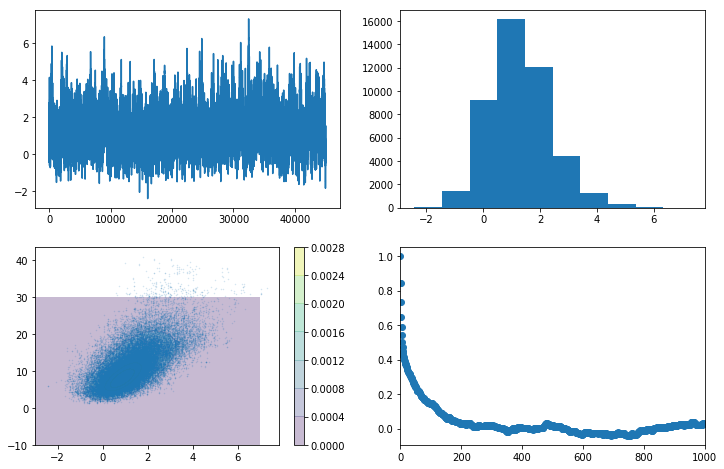

In [15]:
plt.figure(figsize=[12,8])
plt.subplot(2,2,1) 
plt.plot(alpha)
plt.subplot(2,2,2) 
fig=plt.hist(alpha)
plt.subplot(2,2,3)

plt.contourf(X1,X2,pp.T, alpha=0.3)
plt.colorbar()
plt.scatter(alpha, beta, s=0.2, alpha=0.2)
plt.subplot(2,2,4)
plt.acorr(alpha-np.mean(alpha),  normed=True, usevlines=False, maxlags=1000, label=u'Shuffled')

plt.xlim( (0,1000))

In [ ]:
# Thinning
# Thining is a way of reducing autocorrelation from the sample.

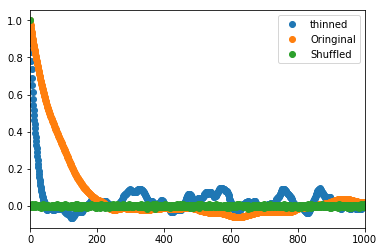

In [16]:
thinint=5
beta_cured=beta[0:len(alpha):thinint]

idp=np.random.permutation(beta)

xt=np.random.normal(size=1000)
#plt.hist(idp)

fig=plt.acorr(beta_cured-np.mean(beta_cured), normed=True, usevlines=False, maxlags=1000, label=u'thinned')
fig=plt.acorr(beta-np.mean(beta), normed=True, usevlines=False, maxlags=1000, label=u'Oringinal')
fig=plt.acorr(idp-np.mean(idp), normed=True, usevlines=False, maxlags=1000, label=u'Shuffled')

plt.xlim( (0,1000))
plt.legend()

In [ ]:
# Series of histograms:

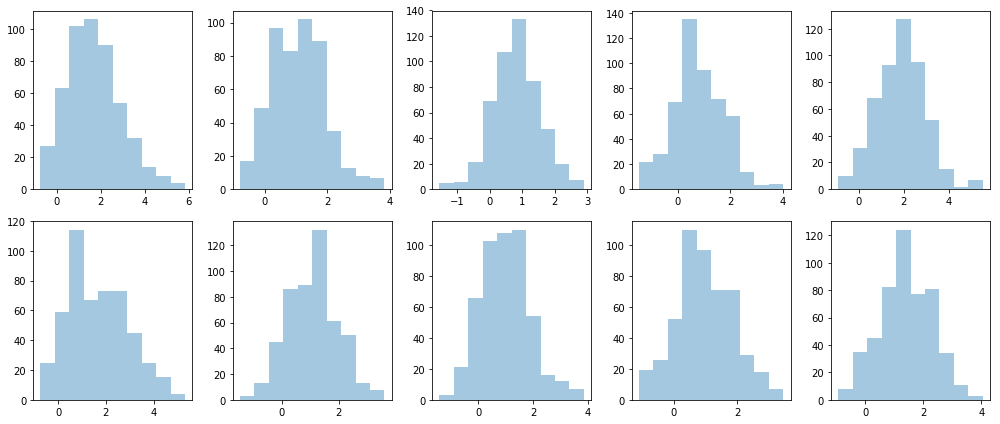

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(14,6))
axes = axes.ravel()
for i in range(10):
    axes[i].hist(alpha[500*i:500*(i+1)], alpha=0.4)
plt.tight_layout()

In [ ]:
# Comparing chains:

In [18]:
n_iter = 50000
trace2, acc2 = metropolis(n_iter, (1,7), 1)
trace, acc = metropolis(n_iter, (1,7), 1)

Iteration 0
Iteration 10000
Iteration 20000
Iteration 30000
Iteration 40000
Iteration 0
Iteration 10000
Iteration 20000
Iteration 30000
Iteration 40000


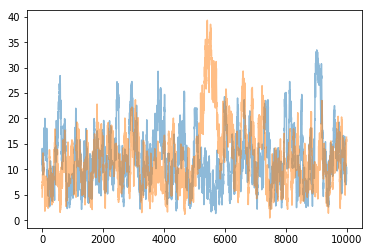

In [19]:
plt.plot( trace[burnin:burnin+10000,1], alpha=0.5)
plt.plot( trace2[burnin:burnin+10000,1], alpha=0.5)

In [20]:
# Formal Methods

In [ ]:
# Example: Estimate maize plant weight given bark diameter and plant height.

In [21]:
D=np.array([2.3,1.9,2.2,2,1.7,1.9,2.2,1.9,2.3,2.3,2.1,2.1,2.1,2.2,2,2.1,2.4,1.9,2.7])
H=np.array([176,177,266,264,203,230,220,230,230,245,240,255,210,250,220,240,165,155,185])
W = np.array([735,355,995,750,500,560,910,725,1040,985,895,910,715,1055,720,755,785,555,970])

In [22]:
# Always start with exploring the data! Lets examine the relationship of $x$ and $w$.

Text(0,0.5,'Weight [g]')

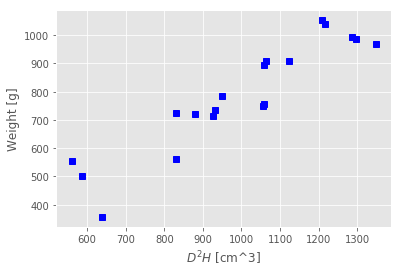

In [25]:
plt.plot(H*D**2, W, 'bs')
plt.xlabel('$D^2 H$ [cm^3]')
plt.ylabel('Weight [g]')

In [26]:
X = H*D**2

model = lambda  beta0,beta1, X : beta0+beta1*X

In [27]:
from scipy.stats import distributions
dgamma = distributions.gamma.logpdf
dnorm = distributions.norm.logpdf
normal = distributions.norm.pdf

def calc_posterior(beta0, beta1, t, y=W, x=X):
    # Calculate joint posterior, given values for a, b and t

    # Priors on beta
    logp = dnorm(beta0, 0, 1000) + dnorm(beta1, 0, 1000)
    # Prior on t
    logp += dgamma(t, 0.001, 0.001)
    # Calculate mu
    mu = beta0 + beta1*x
    # Data likelihood
    logp += sum(dnorm(y, mu, t**-0.5))
    
    return logp

In [29]:
rnorm = np.random.normal
runif = np.random.rand


def metropolis(n_iterations, initial_values, prop_var=1):

    n_params = len(initial_values)
            
    #  proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate posterior for initial values
    current_log_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%1000: print ('Iteration', i)
    
        # Grab current parameter values
        current_params = trace[i]
        p = trace[i].copy() 
        for j in range(n_params):
                 
            # Get current value for parameter j

    
            # Propose new value
            if j==2:
                # Ensure tau is positive
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
            else:
                theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]
            p[j] = trace[i+1,j]  
    return trace, accepted

In [30]:
n_iter = 20000
trace, acc = metropolis(n_iter, (22,0,1), 0.001)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000
Iteration 18000
Iteration 19000


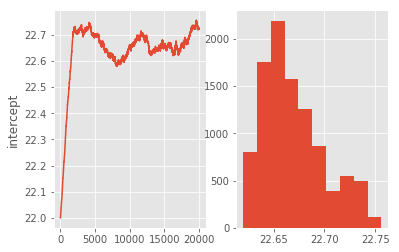

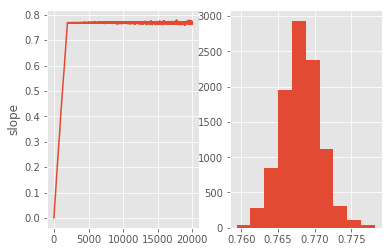

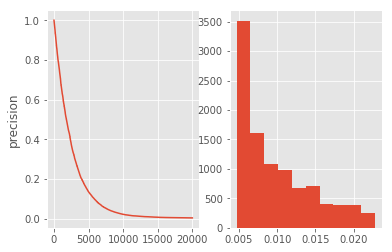

In [34]:
for param, samples in zip(['intercept', 'slope', 'precision'], trace.T):
    fig, axes = plt.subplots(1, 2)
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iter/2):])

In [35]:
b0=np.mean(trace.T[0,4000:])
b1=np.mean(trace.T[1,4000:])
sb0=np.std(trace.T[0,4000:])
sb1=np.std(trace.T[1,4000:])
tau =np.std(trace.T[2,4000:])
print (b0, b1, sb0, sb1, tau, 1.0/np.sqrt(tau))

22.660963772255638 0.7681723269211913 0.037633397478242105 0.002178936991740285 0.04547514192023408 4.689353454965383


In [ ]:
# Using the posterior means we can now look at the resuls (see below for proper Bayes approach to this)

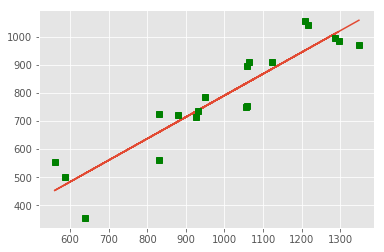

In [36]:
plt.plot(X, model(b0,b1,X))
plt.plot(X, W, 'gs')

In [ ]:
# Geweke test:
# Geweke test is a time-series approach that compares the mean and variance of segments from the beginning 
# and end of a single chain.

(20001, 3)


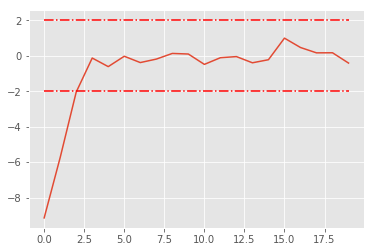

In [42]:
def Geweke(trace, intervals=20, length=200, first=0.1*len(trace)):
    # take two parts of the chain. 
    # subsample lenght 
    nsl=length
    
    z =np.empty(intervals)
    for k in np.arange(0, intervals):
        # beg of each sub samples
        bega=int(first+k*length)
        begb = int(len(trace)/2 + k*length)
        
        
        
        sub_trace_a = trace[bega:bega+nsl]
        sub_trace_b = trace[begb:begb+nsl]
        
        
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        var_a  = np.var(sub_trace_a)
        var_b  = np.var(sub_trace_b)
        
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z

print (trace.shape)
z = Geweke(trace[:,1], first=1000, length=300)

plt.plot( [2]*len(z), 'r-.')
plt.plot(z)
plt.plot( [-2]*len(z), 'r-.')

In [ ]:
# Gelman-Rubin test:

In [43]:
# Predictive probability

In [44]:
asamples, bsamples, tsamples = trace[:,0], trace[:,1], trace[:,2]
asamples=asamples[4000:]
bsamples = bsamples[4000:]
tsamples = tsamples[4000:]
def mu_at_x(x):
    musamples = asamples + x*bsamples
    return musamples

In [45]:
np.mean(mu_at_x(750))

598.7902089631491

In [46]:
def post_pred(xstar):
    musamples = mu_at_x(xstar)
    pp = lambda wstar: np.sum(normal([wstar]*musamples.shape[0], musamples, tsamples**(-0.5)))
    return pp

In [47]:
pp750 = post_pred(750)
#vectorize so we can plot
ppvec750=np.vectorize(pp750)

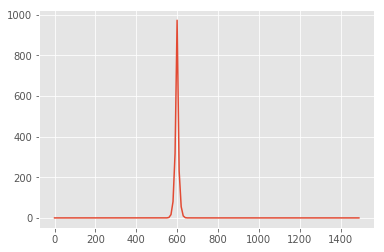

In [48]:
wrange=np.arange(0, 1500, 10)
plt.plot(wrange, ppvec750(wrange))

In [50]:
wrange[np.argmax(ppvec750(wrange))]

a750 = ppvec750(wrange)
print (np.percentile(a750,50))
print (wrange.shape)

2.0973743189476753e-139
(150,)


In [51]:
cdf = np.cumsum(a750)/np.sum(a750)
# get the left and right boundary of the interval that contains 95% of the probability mass 
right=np.argmax(cdf>0.975)
left=np.argmax(cdf>0.025)
print (left, right)

58 62


In [52]:
def lr_credible(s):
    cdf = np.cumsum(s)/np.sum(s)
    # get the left and right boundary of the interval that contains 95% of the probability mass 
    right=np.argmax(cdf>0.975)
    left=np.argmax(cdf>0.025)
    return left, right

In [53]:
predwmax=np.zeros(X.shape[0])
predwl=np.zeros(X.shape[0])
predwr=np.zeros(X.shape[0])
counter=0
for x in X:
    ppfunc = post_pred(x)
    ppfuncvec = np.vectorize(ppfunc)
    watx = ppfuncvec(wrange)
    predwmax[counter]=wrange[np.argmax(watx)]
    l,r = lr_credible(watx)
    predwl[counter]=wrange[l]
    predwr[counter]=wrange[r]
    counter=counter+1

Text(0,0.5,'Predictions')

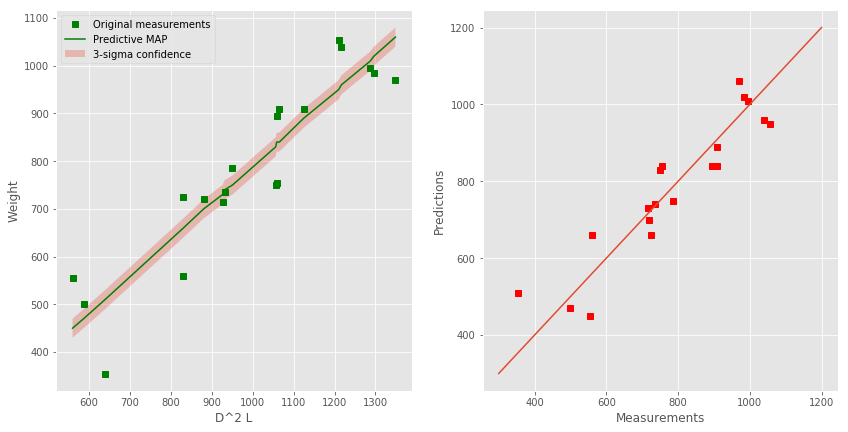

In [54]:
plt.figure(figsize=[14,7])
le=predwmax - predwl
ue=predwr - predwmax


idx = np.argsort(X)
plt.subplot(1,2,1)

plt.plot(X, W, 'gs', label='Original measurements')


plt.plot(X[idx], predwmax[idx], 'g', label='Predictive MAP')
#plt.errorbar(X, predwmax, yerr=[le, ue], fmt='-')
#plt.plot([300,1200],[300,1200])
plt.fill_between(X[idx], predwl[idx], predwr[idx], alpha=0.3, label='3-sigma confidence')
plt.xlabel('D^2 L')
plt.ylabel('Weight')
plt.legend()

plt.subplot(1,2,2)
plt.plot(W, predwmax, 'rs')
plt.plot([300,1200],[300,1200])  # THIS IS A 45 DEGREE LINE 
plt.xlabel('Measurements')
plt.ylabel('Predictions')

In [ ]:
# http://iacs-courses.seas.harvard.edu/courses/am207/blog/lecture-8.html